## RNN for Sine Wave in PyTorch

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
torch.manual_seed(2448)
np.random.seed(2448)


In [27]:
def generate_sinewave(train_len, valid_len):
    time_steps = np.linspace(0, 8 *np.pi, train_len + valid_len)
    data = np.sin(time_steps)
    xs = data[:train_len-1]
    ys = data[1:train_len]
    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

seq_length = 200
portion_length = 0.8
train_len = int(seq_length * portion_length)
valid_len = seq_length - train_len
data, time_steps, train_x, train_y = generate_sinewave(train_len, valid_len)

    

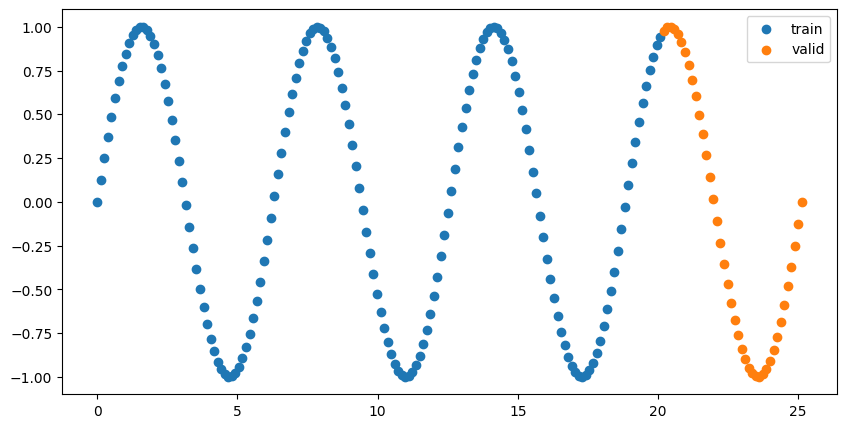

In [30]:
#plot the data 
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(time_steps[:train_len], data[:train_len], label = 'train')
plt.scatter(time_steps[train_len:], data[train_len:], label = 'valid')
ax.legend()
plt.show()

Epoch 0: loss 0.5921087265014648
Epoch 10: loss 0.10034462064504623
Epoch 20: loss 0.0167451873421669
Epoch 30: loss 0.006509426049888134
Epoch 40: loss 0.0025078831240534782
Epoch 50: loss 0.0011011622846126556
Epoch 60: loss 0.0005554214585572481
Epoch 70: loss 0.0003758830716833472
Epoch 80: loss 0.00023973164206836373
Epoch 90: loss 0.000167375648743473
Epoch 100: loss 0.00011972271022386849
Epoch 110: loss 8.516051457263529e-05
Epoch 120: loss 5.97122052568011e-05
Epoch 130: loss 4.238089968566783e-05
Epoch 140: loss 3.0848823371343315e-05
Epoch 150: loss 2.3385688109556213e-05
Epoch 160: loss 1.8538872609497048e-05
Epoch 170: loss 1.5266543414327316e-05
Epoch 180: loss 1.292505839955993e-05
Epoch 190: loss 1.1175243344041519e-05
Epoch 200: loss 9.82144774752669e-06
Epoch 210: loss 8.742970749153756e-06
Epoch 220: loss 7.859169272705913e-06
Epoch 230: loss 7.114322670531692e-06
Epoch 240: loss 6.4717714849393815e-06
Epoch 250: loss 5.9065687310067005e-06
Epoch 260: loss 5.40301243

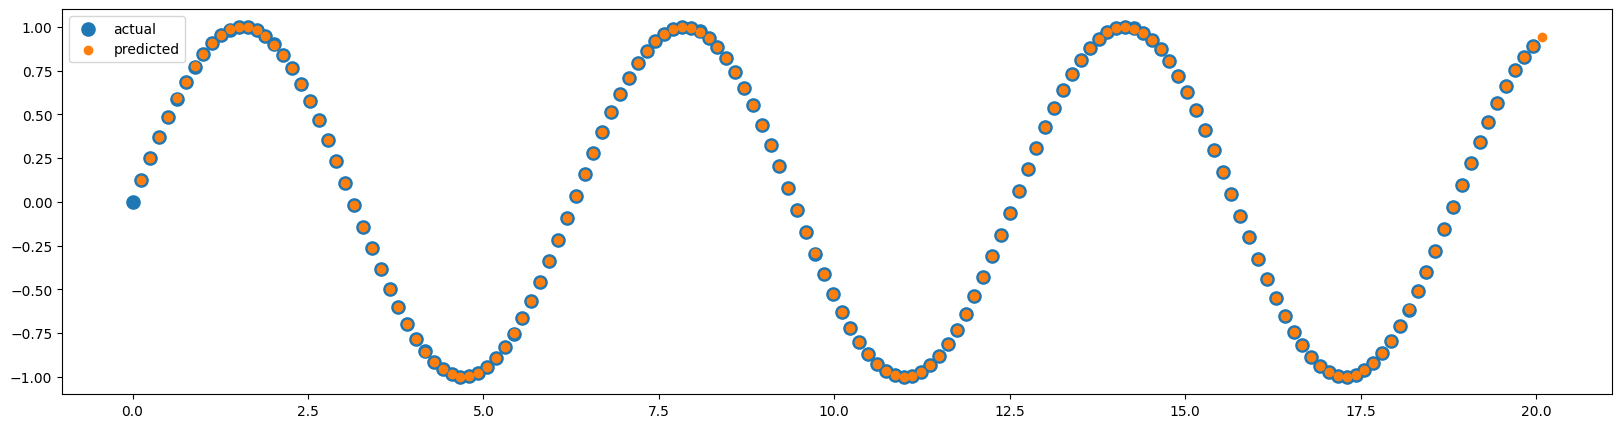

In [32]:
class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x_t, state):
        h_prev = state        
        a = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        h = torch.sigmoid(a)
        return h
    
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, 1) 

    def init_hidden(self,):
        return torch.zeros(1,self.hidden_size) 
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []
        for X_t in X:
            
            self.h = self.rnn_cell.forward(X_t, self.h)
            y_t = self.linear.forward(self.h)
            outputs.append(y_t)
        return torch.stack(outputs), self.h
        
hidden_size = 40
learning_rate = 0.01

model = RNN(1,hidden_size) 

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), learning_rate) 
epochs = 1000 #500 
for epoch in range(epochs):
    optimizer.zero_grad()   
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss.item()}")

        
def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    for i in range(train_x.shape[0]):
        input = train_x[i]
        input = input.view(1, 1, 1)        
        pred, hidden_prev = model(input, hidden_prev) 
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()


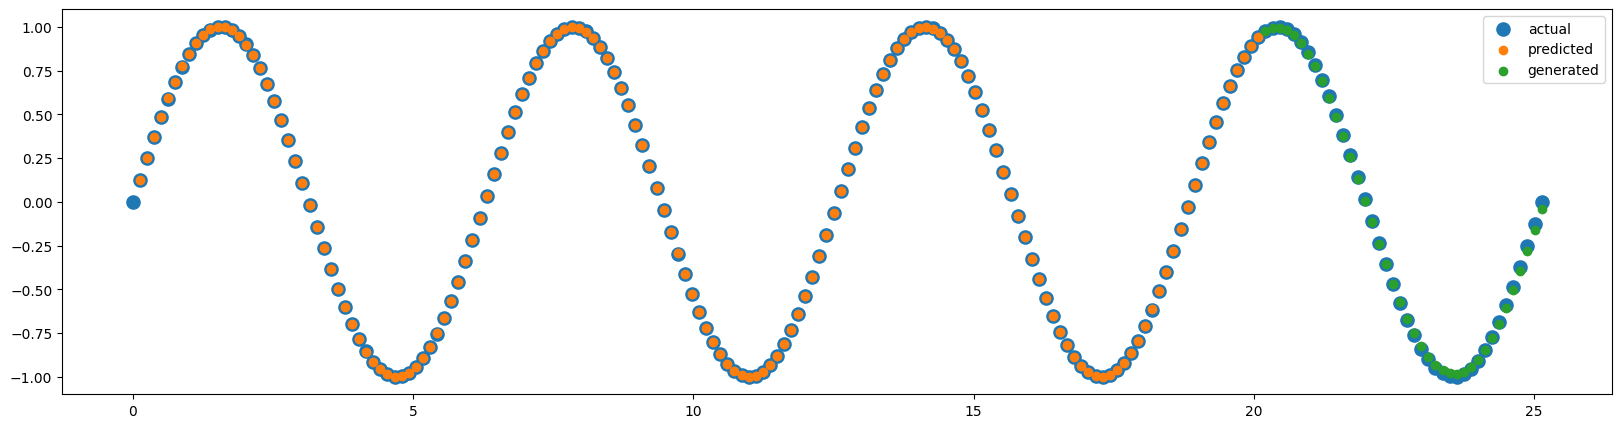

In [33]:
# Test RNN state

def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

## LSTM using Tensorflow

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

## Data Preperation
def seq_data(x, seq_length):
    X = []
    Y = []
    l = len(x)
    
    for i in range(l):
        end_id = i + seq_length
        if end_id > len(x) - 1:
            print("end id could not be bigger than series length")
            break    
        X.append(x[i:end_id])
        Y.append(x[end_id])
        
    return np.array(X), np.array(Y)
x_sin = np.arange(0, 100, 0.1)
y_sin = np.sin(x_sin)
x_test = np.linspace(0, 100, 1000, endpoint=True)
y_test = np.sin(x_test)

x_test_plot = np.copy(x_test)
y_test_plot = np.copy(y_test)

seq_length = 20

x_train, y_train = seq_data(y_sin, seq_length) 
x_test, y_test = seq_data(y_test, seq_length) 

num_features = 1
train_shape = x_train.shape
test_shape = x_test.shape

x_train = x_train.reshape((train_shape[0], train_shape[1], num_features))
x_test = x_test.reshape((test_shape[0], test_shape[1], num_features))


model = Sequential()
model.add(LSTM(10, input_shape = (seq_length, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


h = model.fit(x_train, y_train, epochs=20, verbose=1)
y_predict = model.predict(x_test)

pred_x = np.arange(80, 200, 0.1)
pred_y = np.sin(pred_x)
results = []
test_y = pred_y[:seq_length]

for i in range( len(pred_x) - seq_length):
    net_input = test_y[i : i + seq_length]
    net_input = net_input.reshape((1, seq_length, num_features))
    y = model.predict(net_input, verbose=0)
    test_y = np.append(test_y, y)



end id could not be bigger than series length
end id could not be bigger than series length
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4937
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3065
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2091
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1450
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0984
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0610
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

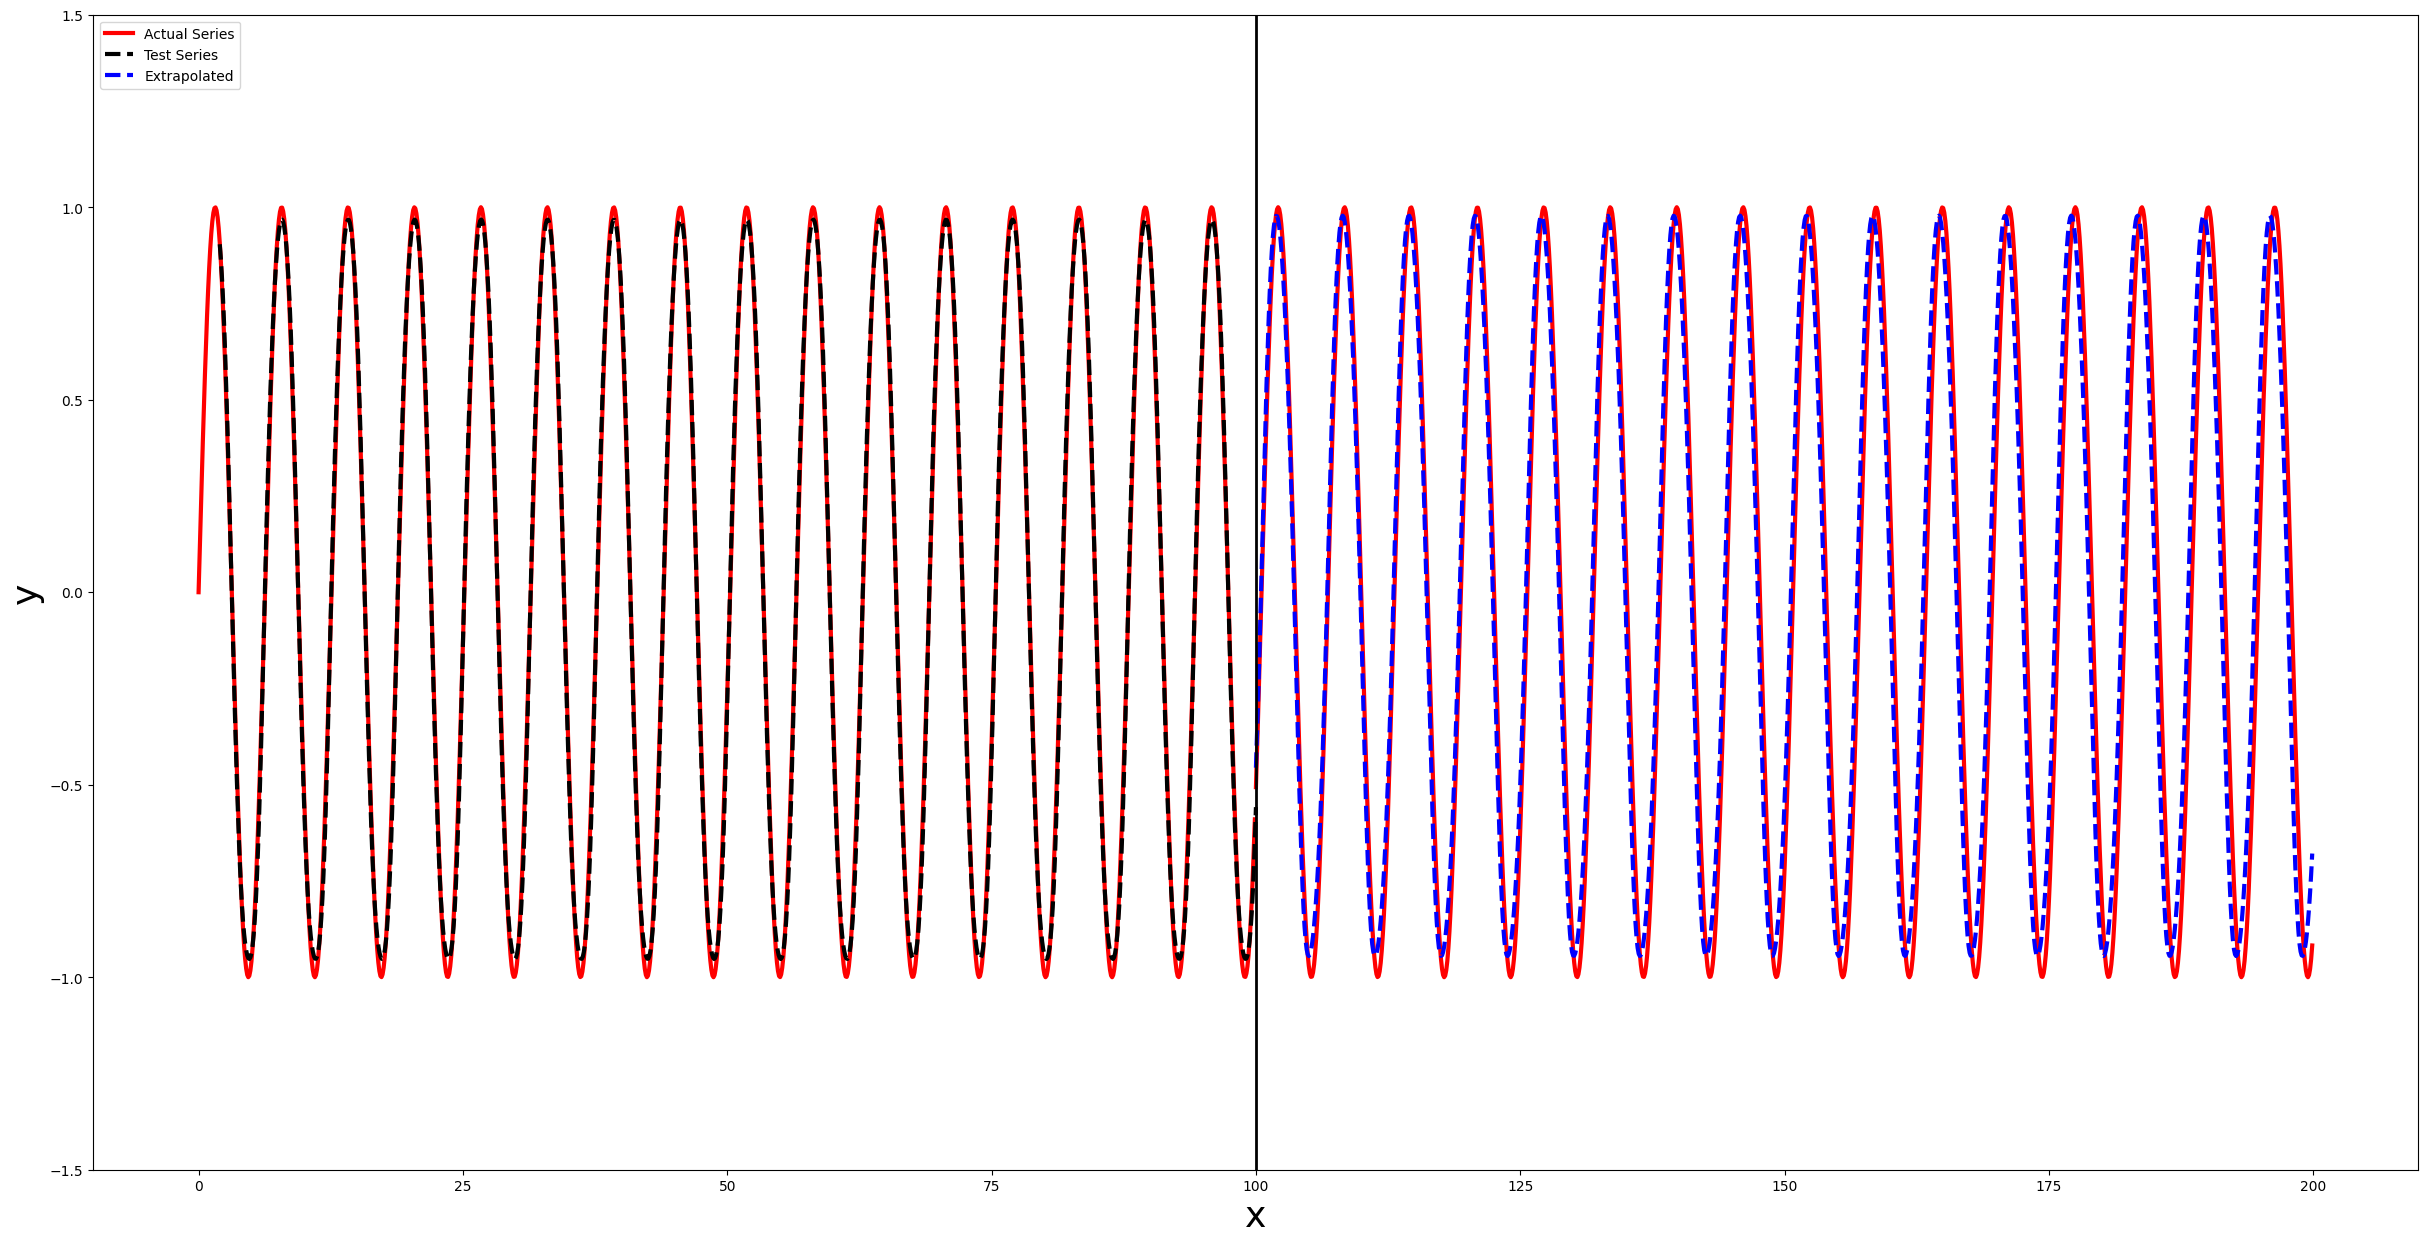

In [36]:
x_ext = np.arange(100, 200, 0.1)
y_ext = np.sin(x_ext)


fig, ax = plt.subplots(figsize=(30,15))
ax.set_xlabel('x', fontsize=26)
ax.set_ylabel('y', fontsize=26)

ax.plot(x_sin, y_sin, "-r", linewidth = 3.0, label="Actual Series")
ax.plot(x_ext, y_ext, "-r", linewidth = 3.0)

ax.plot(x_test_plot[seq_length:], y_predict, "--k", linewidth = 3.0, label="Test Series")
ind = int(seq_length/0.1)
ax.plot(pred_x[ind:], test_y[ind:], "--b", linewidth=3.0, label="Extrapolated")
ax.legend(loc='upper left')
ax.vlines(100, -1.5, 1.5, colors="black", linestyles='solid', linewidth=2.0)   

ax.set_ylim(-1.5, 1.5)
plt.show()